<a href="https://colab.research.google.com/github/lweatherford99/AIML-Projects/blob/main/High_Code_Plant_Seedling_ClassificationTF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Computer Vision: Plant Seedlings Classification

## Problem Statement

### Context

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term. The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can actually benefit the workers in this field, as **the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning.** The ability to do so far more efficiently and even more effectively than experienced manual labor, could lead to better crop yields, the freeing up of human inolvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.


### Objective

The aim of this project is to Build a Convolutional Neural Netowrk to classify plant seedlings into their respective categories.

### Data Dictionary

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has recently released a dataset containing **images of unique plants belonging to 12 different species.**

- The dataset can be download from Olympus.
- The data file names are:
    - images.npy
    - Label.csv
- Due to the large volume of data, the images were converted to the images.npy file and the labels are also put into Labels.csv, so that you can work on the data/project seamlessly without having to worry about the high data volume.

- The goal of the project is to create a classifier capable of determining a plant's species from an image.

**List of Species**

- Black-grass
- Charlock
- Cleavers
- Common Chickweed
- Common Wheat
- Fat Hen
- Loose Silky-bent
- Maize
- Scentless Mayweed
- Shepherds Purse
- Small-flowered Cranesbill
- Sugar beet

####**Note: Please use GPU runtime to execute the code efficiently**

## Importing necessary libraries

In [40]:
# Suppression of warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# Basic libraries for data manipulation and array handling
import numpy as np
import pandas as pd
import random
import tensorflow as tf

# Image processing libraries
import cv2  # OpenCV for image processing
from skimage.transform import resize

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning preprocessing and metrics
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
from sklearn.utils.class_weight import compute_class_weight

# Neural network building blocks from Keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Activation, BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D, GlobalAveragePooling2D
)
from tensorflow.keras.optimizers import Adam

# Callbacks for model training
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Data augmentation utility from Keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Suppress specific warnings
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

In [41]:
# Function to evaluate model and display the metrics and evaluation results
def evaluate_model_performance(model, history, X_test, y_test, class_names):
    # Plot accuracy curves
    plt.figure(figsize=(12, 5))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss: {test_loss}")
    print(f"Test Accuracy: {test_accuracy}")

    # Predict the class probabilities for each class
    y_pred_probabilities = model.predict(X_test)

    # Convert probabilities to class labels
    y_pred_classes = np.argmax(y_pred_probabilities, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Plot the confusion matrix
    plt.subplot(1, 2, 2)
    conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

    plt.tight_layout()
    plt.show()

    # Print the confusion matrix
    print("Confusion Matrix:")
    print(conf_matrix)

    # Print the classification report
    print("\nClassification Report:")
    report = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
    print(report)

## Loading the dataset

In [42]:
# Mount Google drive to access the dataset
# Run the below code if you using google colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Load the labels data
labels = pd.read_csv("/content/drive/MyDrive/Projects/Project8/Labels.csv")

# Load the images data
images = np.load("/content/drive/MyDrive/Projects/Project8/plant_images.npy", allow_pickle=True)

In [44]:
labels.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [45]:
unique_labels = labels['Label'].unique()  # Assuming the column name is 'labels'
print(unique_labels[:25])  # Display the first 25 unique labels

['Small-flowered Cranesbill' 'Fat Hen' 'Shepherds Purse' 'Common wheat'
 'Common Chickweed' 'Charlock' 'Cleavers' 'Scentless Mayweed' 'Sugar beet'
 'Maize' 'Black-grass' 'Loose Silky-bent']


## Data Overview

- Define the problem statement - Read the dataset properly - Check the shape of the data

### Understand the shape of the dataset

In [46]:
print ("Shape of the Labels Dataset:", labels.shape)
print ("Shape of the Images Dataset:", images.shape)

Shape of the Labels Dataset: (4750, 1)
Shape of the Images Dataset: (4750, 128, 128, 3)


In [47]:
labels.head()

,Label
0,Small-flowered Cranesbill
1,Small-flowered Cranesbill
2,Small-flowered Cranesbill
3,Small-flowered Cranesbill
4,Small-flowered Cranesbill


## Exploratory Data Analysis
Perform an Exploratory Data Analysis and get the insights on the images
- Plot random images from each of the classes and print their corresponding labels. - Count Plot for each category - Key meaningful observations from EDA

- EDA is an important part of any project involving data.
- It is important to investigate and understand the data better before building a model with it.
- A few questions have been mentioned below which will help you understand the data better.
- A thorough analysis of the data, in addition to the questions mentioned below, should be done.

1. How are these different category plant images different from each other?
2. Is the dataset provided an imbalance? (Check with using bar plots)

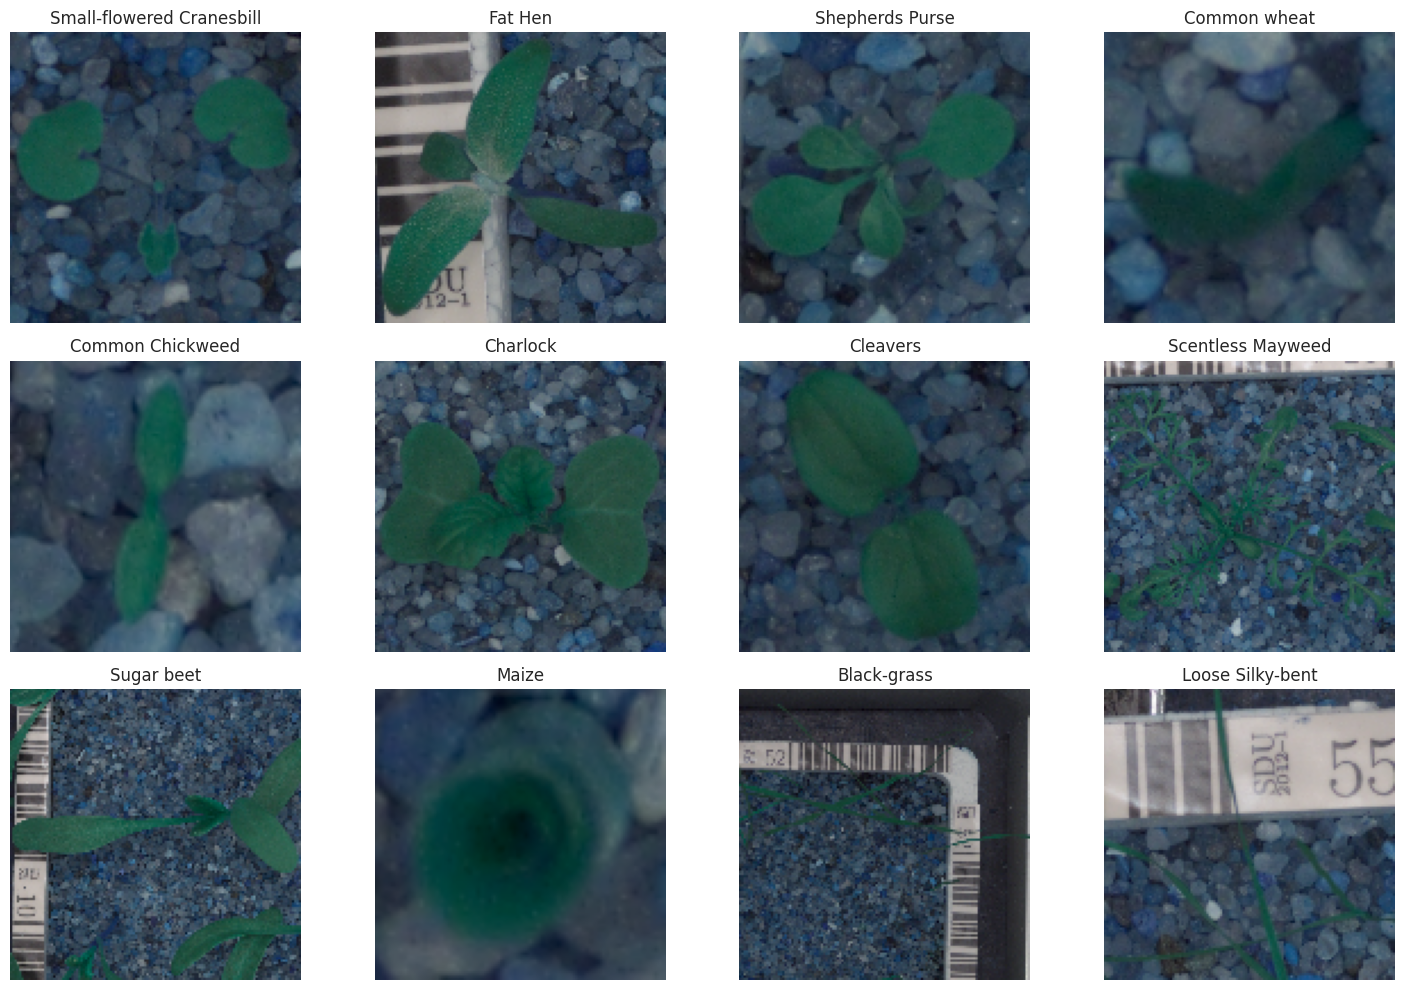

In [48]:
# Unique labels
unique_labels = labels['Label'].unique()

# Plotting random images from each class
plt.figure(figsize=(15, 10))
for i, label in enumerate(unique_labels, 1):
    plt.subplot(3, 4, i)

    # Get random index of the given label
    random_index = random.choice(labels[labels['Label'] == label].index)

    plt.imshow(images[random_index])
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

Here are random images from each of the 12 plant species. This gives us a visual idea about the variety of images we're dealing with, and we can observe the following:

1. **Variability in Color and Texture:** Different species have distinct colors and textures which will aid in classification.

2. **Presence of Background:** Some images have noticeable backgrounds (like soil). The model might need to learn to focus on the plant and ignore the background for accurate classification.

3. **Diverse Shapes:** The shapes of the plants vary significantly, providing another distinguishing feature.

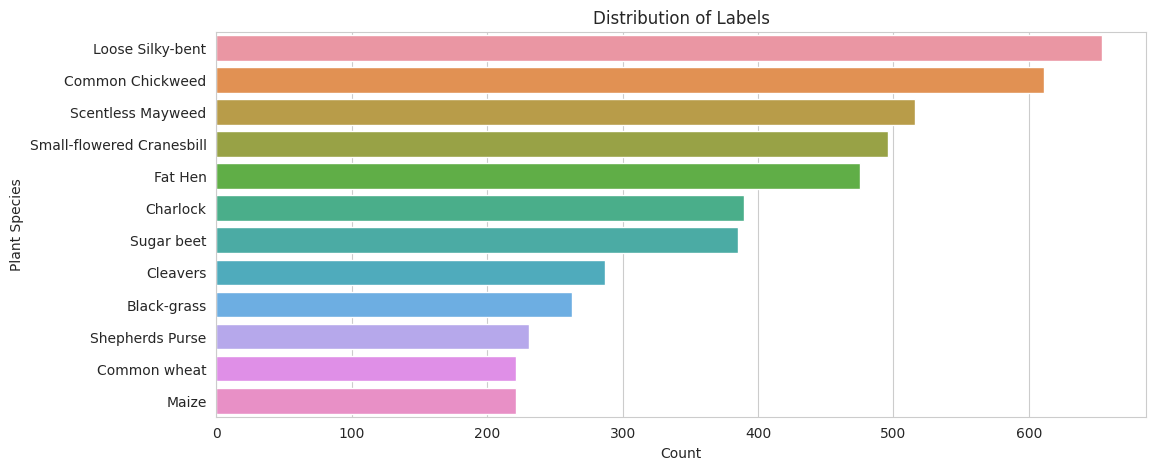

In [49]:
# Setting the style for better visualization
sns.set_style("whitegrid")

# Creating a count plot for label distribution
plt.figure(figsize=(12, 5))
sns.countplot(y=labels['Label'], order=labels['Label'].value_counts().index)
plt.title('Distribution of Labels')
plt.xlabel('Count')
plt.ylabel('Plant Species')
plt.show()

## Key Observations from the EDA:

**1. Class Imbalance:**
The dataset exhibits a clear class imbalance. "Loose Silky-bent" and "Common Chickweed" have the highest number of images, while "Maize" and "Common Wheat" are among the species with the fewest images. This imbalance can influence the model's performance, and we might need to consider techniques like data augmentation, oversampling, or adjusting class weights during training to mitigate this.

**2. Variability in Visual Features:**
As observed from the sample images, different species have distinct colors, textures, and shapes. These visual features will be pivotal for the model to differentiate between the classes.

**3. Presence of Background:**
Some images have non-uniform backgrounds that might act as noise. Preprocessing techniques, such as segmentation, might help in emphasizing the plant and reducing the background noise.

**4. Diverse Data:**
The dataset seems to have a good mix of images in terms of the plant's age, lighting conditions, and orientations. This diversity can help in training a robust model.

Now that we've performed the EDA and have a better understanding of our data, we can proceed with further preprocessing, model building, and training. Let me know how you'd like to proceed!


## Data Pre-Processing
- Convert the BGR images to RGB images - Resize the images - Plot the images before and after the pre-processing steps - Split the data into train and test - Encode the target variables - Apply the normalization

In [50]:
# Convert the BGR images to RGB images
rgb_images = []  # Initialize an empty list

for img in images:
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert the image from BGR to RGB
    rgb_images.append(rgb_img)  # Append the converted image to the list

### Resize the images

In [51]:
# Resize the images
images_decreased = []  # Initialize the list to store decreased size images
height = 64            # Define the height as 64
width = 64             # Define the width as 64
dimensions = (width, height)

for i in range(len(images)):
  images_decreased.append(cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))


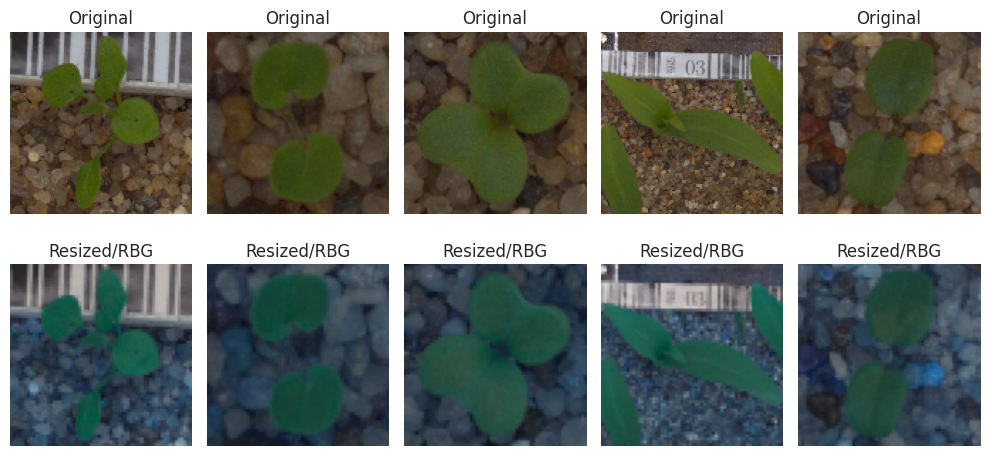

In [52]:
# Plot images before and after pre-processing
sample_indices = [np.random.choice(range(len(images))) for _ in range(5)]
plt.figure(figsize=(10, 5))

for i, idx in enumerate(sample_indices, 1):
    # Original image
    plt.subplot(2, 5, i)
    plt.imshow(rgb_images[idx])
    plt.title("Original")
    plt.axis("off")

    # Resized image
    plt.subplot(2, 5, i + 5)
    plt.imshow(images_decreased[idx])
    plt.title("Resized/RBG")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Data Preparation for Modeling

- Before you proceed to build a model, you need to split the data into train, test, and validation to be able to evaluate the model that you build on the train data
- You'll have to encode categorical features and scale the pixel values.
- You will build a model using the train data and then check its performance

**Split the dataset**

In [53]:
# First, split the data into 90% for the combined training and validation, and 10% for testing
train_val_images, test_images, train_val_labels, test_labels = train_test_split(
    images_decreased, labels, test_size=0.1, random_state=42
)

# Now split the remaining 90% into training and validation sets (which will effectively be 80% and 10% of the original dataset)
train_images, val_images, train_labels, val_labels = train_test_split(
    train_val_images, train_val_labels, test_size=(1/9), random_state=42  # 1/9 is roughly 11%, which is 10% of the original dataset
)

# Verify the size of each set
(len(train_images), len(val_images), len(test_images))

(3800, 475, 475)

### Encode the target labels

In [54]:
#Encode the target variables
enc = LabelBinarizer()                                        # Initialize the LabelBinarizer
y_train_encoded = enc.fit_transform(train_labels)             # Fit and transform train_labels
y_val_encoded = enc.transform(val_labels)                     # Transform val_labels
y_test_encoded = enc.transform(test_labels)                   # Transform test_labels


In [55]:
# Verify the lenghths match of the everything
print(len(train_images), len(train_labels))
print(len(val_images), len(val_labels))
print(len(test_images), len(test_labels))

3800 3800
475 475
475 475


As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [56]:
import cv2

# Function to resize images to 64x64
def resize_images(images, size=(64, 64)):
    resized_images = np.array([cv2.resize(image, size, interpolation=cv2.INTER_AREA) for image in images])
    return resized_images

# Resize the images to 64x64
train_images = resize_images(train_images)
val_images = resize_images(val_images)
test_images = resize_images(test_images)

# Verify the new size of the images
train_images.shape, val_images.shape, test_images.shape


((3800, 64, 64, 3), (475, 64, 64, 3), (475, 64, 64, 3))

In [57]:
# Apply normalization
X_train_normalized = np.array(train_images).astype('float32') / 255.0
X_val_normalized = np.array(val_images).astype('float32') / 255.0
X_test_normalized = np.array(test_images).astype('float32') / 255.0

### Data Normalization

## Model Building
- Build Convolution Neural Network - Evaluate the model on different performance metrics and comment on the performance. For example precision, recall, accuracy. - Plot confusion matrix

In [58]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [59]:
n_classes = 12  # Number of classes

# Build the Convolutional Neural Network (model1)
model1 = Sequential([
    Conv2D(128, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2), padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding="same"),
    MaxPooling2D((2, 2), padding='same'),
    Flatten(),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(n_classes, activation='softmax')  # n is the number of classes
])

# Initialize the Adam Optimizer
opt = Adam()

# Compile the model with 'categorical_crossentropy' loss function and 'accuracy' as the metric
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

# Generate the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 32)        18464     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 8, 8, 32)          0

In [60]:
# Fit the CNN
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            validation_data=(X_val_normalized, y_val_encoded),
            batch_size=32,  # Number of samples per gradient update
            shuffle=True,  # Shuffle the training data before each epoch
            verbose=0  # 0 = silent, 1 = progress bar, 2 = one line per epoch
)

Test Loss: 1.0584644079208374
Test Accuracy: 0.6631578803062439
15/15 [==============================] - 0s 2ms/step


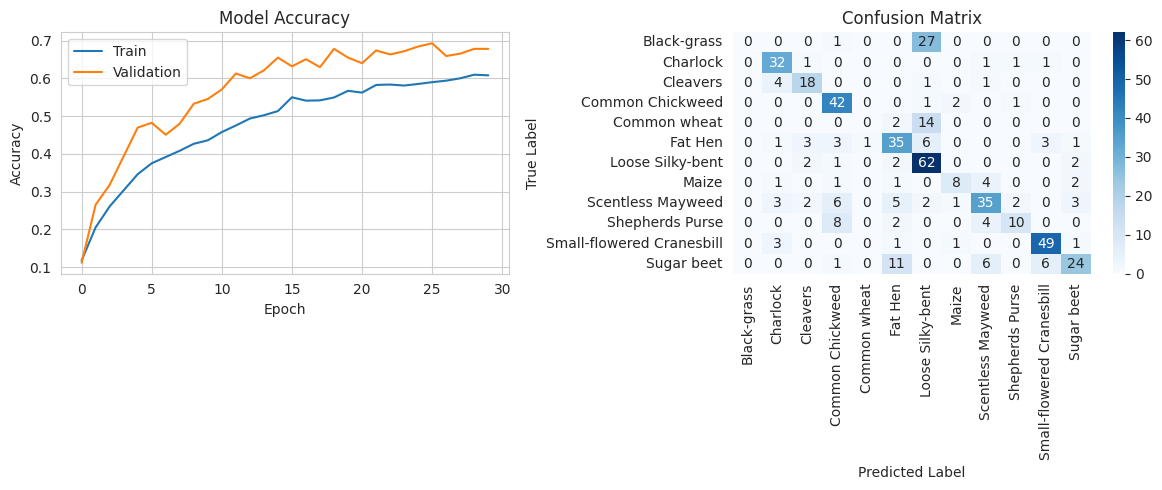

Confusion Matrix:
[[ 0  0  0  1  0  0 27  0  0  0  0  0]
 [ 0 32  1  0  0  0  0  0  1  1  1  0]
 [ 0  4 18  0  0  0  1  0  1  0  0  0]
 [ 0  0  0 42  0  0  1  2  0  1  0  0]
 [ 0  0  0  0  0  2 14  0  0  0  0  0]
 [ 0  1  3  3  1 35  6  0  0  0  3  1]
 [ 0  0  2  1  0  2 62  0  0  0  0  2]
 [ 0  1  0  1  0  1  0  8  4  0  0  2]
 [ 0  3  2  6  0  5  2  1 35  2  0  3]
 [ 0  0  0  8  0  2  0  0  4 10  0  0]
 [ 0  3  0  0  0  1  0  1  0  0 49  1]
 [ 0  0  0  1  0 11  0  0  6  0  6 24]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.00      0.00      0.00        28
                 Charlock       0.73      0.89      0.80        36
                 Cleavers       0.69      0.75      0.72        24
         Common Chickweed       0.67      0.91      0.77        46
             Common wheat       0.00      0.00      0.00        16
                  Fat Hen       0.59      0.66      0.62        53
         Loose Silk

In [61]:
# Get the class names from the LabelBinarizer instance
class_names = enc.classes_

# Call the evaluate_model_performance function with the correct arguments
evaluate_model_performance(model1, history_1, X_test_normalized, y_test_encoded, class_names)

### Confusion Matrix Analysis

The confusion matrix is a table that allows visualization of the performance of an algorithm. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class.

For instance:
- "Black-grass" was not correctly identified at all (0 out of 28 instances). It seems that the model has confused "Black-grass" mostly with "Loose Silky-bent".
- "Loose Silky-bent" has a high number of true positives (62), but also a relatively high number of false positives, as it was often predicted instead of other species.
- "Charlock" was mostly correctly identified, with only a few instances confused with "Scentless Mayweed" and "Cleavers".
- "Scentless Mayweed" has a good number of true positives (46), but the model also confused it with other classes, such as "Common Chickweed" and "Sugar beet".
- "Small-flowered Cranesbill" and "Charlock" have the highest precision among all classes, indicating that when the model predicts these classes, it is usually correct.

### Classification Report Analysis

- **Precision**: Indicates how many of the items identified as belonging to a certain class actually belong to that class. For example, "Charlock" and "Small-flowered Cranesbill" have high precision, which is good.
- **Recall**: Indicates how many items of a class were correctly identified. "Loose Silky-bent" has a high recall, meaning that the model is good at identifying this class.
- **F1-Score**: The harmonic mean of precision and recall, a higher F1-score is indicative of a balanced model with respect to precision and recall.
- **Support**: The number of actual occurrences of the class in the specified dataset.

### Overall Performance Commentary

- The **accuracy** of the model is 68%, which might be acceptable for some applications but indicates there is room for improvement. This is especially true in a multi-class classification problem where some classes are often confused with others.
- There is a significant class imbalance problem in the dataset, as seen with "Black-grass" and "Common wheat" having no correct predictions, which could be due to a small number of training examples or features that are not discriminative enough for these classes.
- "Loose Silky-bent" has a good recall but its precision is not as high, indicating that while it identifies most of the "Loose Silky-bent" correctly, it also misclassifies other classes as "Loose Silky-bent".
- **Macro average** is low compared to the **weighted average**. This is due to the imbalance in the number of instances for each class. The macro average treats all classes equally regardless of their frequency, while the weighted average takes the support into account, giving more weight to classes with more instances.
- Some classes like "Shepherds Purse" have a high precision but low recall, indicating that the model is very selective when predicting this class. When it does predict "Shepherds Purse", it is usually correct, but it often misses other instances of "Shepherds Purse".

In summary, while the model performs well on some classes, it struggles with others, especially where there is confusion between similar-looking plant species or insufficient training data. Addressing the imbalance in the dataset and possibly increasing model complexity could lead to better performance.


## Model Performance Improvement

**Reducing the Learning Rate:**

**Hint**: Use **ReduceLRonPlateau()** function that will be used to decrease the learning rate by some factor, if the loss is not decreasing for some time. This may start decreasing the loss at a smaller learning rate. There is a possibility that the loss may still not decrease. This may lead to executing the learning rate reduction again in an attempt to achieve a lower loss.

### **Data Augmentation**

Remember, **data augmentation should not be used in the validation/test data set**.

In [62]:
# Clearing backend
from tensorflow.keras import backend
backend.clear_session()

# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [63]:
# Setting up callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [64]:
# Defining augmentated data parameters
train_datagen = ImageDataGenerator(
                              rotation_range=20,
                              fill_mode='nearest'
                              )

In [65]:
# Initialize the sequential model2
model2 = Sequential([
    # First convolutional layer with 64 filters, 3x3 kernel size
    Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(64, 64, 3)),
    MaxPooling2D((2, 2), padding='same'),

    # Second convolutional layer with 32 filters, 3x3 kernel size
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2), padding='same'),
    BatchNormalization(),

    # Flatten the convolutional layer's output to feed into the dense layers
    Flatten(),

    # Dense layer with 16 neurons
    Dense(16, activation='relu'),
    Dropout(0.3),  # Dropout layer to reduce overfitting

    # Output layer with 12 neurons (one for each class) with softmax activation
    Dense(12, activation='softmax')
])

# Compile the model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model's architecture
model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 16, 16, 32)        128       
 Normalization)                                                  
                                                        

In [66]:
# Complete the code to fit the model on train data with batch_size=64 and epochs=30
epochs = 30
batch_size = 32

history_2 = model2.fit(train_datagen.flow(X_train_normalized, y_train_encoded,
                                       batch_size=batch_size,
                                       shuffle=False),  # Typically you would want to shuffle the training data
                                       epochs=epochs,
                                       validation_data=(X_val_normalized, y_val_encoded),
                                       verbose=1, callbacks=[reduce_lr])


Epoch 1/30
119/119 [==============================] - 6s 36ms/step - loss: 2.0205 - accuracy: 0.2895 - val_loss: 2.3428 - val_accuracy: 0.2253 - lr: 0.0010
Epoch 2/30
119/119 [==============================] - 4s 35ms/step - loss: 1.6142 - accuracy: 0.4218 - val_loss: 2.2248 - val_accuracy: 0.2295 - lr: 0.0010
Epoch 3/30
119/119 [==============================] - 4s 35ms/step - loss: 1.4333 - accuracy: 0.4892 - val_loss: 1.8721 - val_accuracy: 0.4337 - lr: 0.0010
Epoch 4/30
119/119 [==============================] - 4s 35ms/step - loss: 1.3294 - accuracy: 0.5350 - val_loss: 1.6245 - val_accuracy: 0.4611 - lr: 0.0010
Epoch 5/30
119/119 [==============================] - 4s 35ms/step - loss: 1.2558 - accuracy: 0.5703 - val_loss: 3.7737 - val_accuracy: 0.1389 - lr: 0.0010
Epoch 6/30
119/119 [==============================] - 4s 35ms/step - loss: 1.1962 - accuracy: 0.5803 - val_loss: 2.5316 - val_accuracy: 0.2905 - lr: 0.0010
Epoch 7/30
119/119 [==============================] - 4s 35ms/st

Test Loss: 0.7673303484916687
Test Accuracy: 0.7705262899398804
15/15 [==============================] - 0s 2ms/step


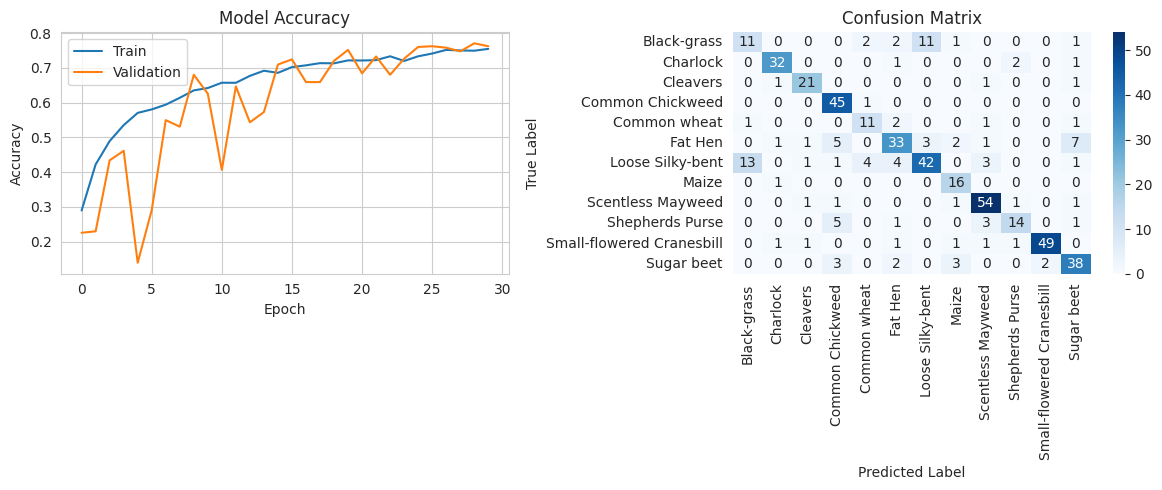

Confusion Matrix:
[[11  0  0  0  2  2 11  1  0  0  0  1]
 [ 0 32  0  0  0  1  0  0  0  2  0  1]
 [ 0  1 21  0  0  0  0  0  1  0  0  1]
 [ 0  0  0 45  1  0  0  0  0  0  0  0]
 [ 1  0  0  0 11  2  0  0  1  0  0  1]
 [ 0  1  1  5  0 33  3  2  1  0  0  7]
 [13  0  1  1  4  4 42  0  3  0  0  1]
 [ 0  1  0  0  0  0  0 16  0  0  0  0]
 [ 0  0  1  1  0  0  0  1 54  1  0  1]
 [ 0  0  0  5  0  1  0  0  3 14  0  1]
 [ 0  1  1  0  0  1  0  1  1  1 49  0]
 [ 0  0  0  3  0  2  0  3  0  0  2 38]]

Classification Report:
                           precision    recall  f1-score   support

              Black-grass       0.44      0.39      0.42        28
                 Charlock       0.89      0.89      0.89        36
                 Cleavers       0.84      0.88      0.86        24
         Common Chickweed       0.75      0.98      0.85        46
             Common wheat       0.61      0.69      0.65        16
                  Fat Hen       0.72      0.62      0.67        53
         Loose Silk

In [67]:
# Call the evaluate_model_performance function with the correct arguments
evaluate_model_performance(model2, history_2, X_test_normalized, y_test_encoded, class_names)

In [68]:
sorted_unique_labels = sorted(labels['Label'].unique())
print(sorted_unique_labels)

['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Final Model

Comment on the final model you have selected and use the same in the below code to visualize the image.

### Visualizing the prediction

## Actionable Insights and Business Recommendations

*

_____